In [1]:
import torch
from torch.optim.adam import Adam
import torch.nn.functional as nnf
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers.configuration_utils import FrozenDict
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from diffusers.utils import deprecate, logging
from diffusers.utils import BaseOutput, is_torch_available, is_transformers_available

import numpy as np
import PIL
from PIL import Image
from tqdm.notebook import tqdm
import inspect
import warnings
from dataclasses import dataclass
from itertools import repeat
from typing import Callable, List, Optional, Union, Tuple, Dict, Optional

In [2]:
def register_attention_control(model, controller):
    def ca_forward(self, place_in_unet):
        to_out = self.to_out
        if type(to_out) is torch.nn.modules.container.ModuleList:
            to_out = self.to_out[0]
        else:
            to_out = self.to_out

        def forward(x, context=None, mask=None):
            batch_size, sequence_length, dim = x.shape
            h = self.heads
            q = self.to_q(x)
            is_cross = context is not None
            context = context if is_cross else x
            k = self.to_k(context)
            v = self.to_v(context)
            q = self.reshape_heads_to_batch_dim(q)
            k = self.reshape_heads_to_batch_dim(k)
            v = self.reshape_heads_to_batch_dim(v)

            sim = torch.einsum("b i d, b j d -> b i j", q, k) * self.scale

            if mask is not None:
                mask = mask.reshape(batch_size, -1)
                max_neg_value = -torch.finfo(sim.dtype).max
                mask = mask[:, None, :].repeat(h, 1, 1)
                sim.masked_fill_(~mask, max_neg_value)

            # attention, what we cannot get enough of
            attn = sim.softmax(dim=-1)
            attn = controller(attn, is_cross, place_in_unet)
            out = torch.einsum("b i j, b j d -> b i d", attn, v)
            out = self.reshape_batch_dim_to_heads(out)
            return to_out(out)

        return forward

    class DummyController:

        def __call__(self, *args):
            return args[0]

        def __init__(self):
            self.num_att_layers = 0

    if controller is None:
        controller = DummyController()

    def register_recr(net_, count, place_in_unet):
        if net_.__class__.__name__ == 'CrossAttention':
            net_.forward = ca_forward(net_, place_in_unet)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    cross_att_count = 0
    sub_nets = model.unet.named_children()
    for net in sub_nets:
        if "down" in net[0]:
            cross_att_count += register_recr(net[1], 0, "down")
        elif "up" in net[0]:
            cross_att_count += register_recr(net[1], 0, "up")
        elif "mid" in net[0]:
            cross_att_count += register_recr(net[1], 0, "mid")

    controller.num_att_layers = cross_att_count


def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image

class NullInversion:
    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,set_alpha_to_one=False)
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None
    
    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample
    
    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample
    
    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = torch.cat([latents] * 2)
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE
        noise_pred = self.model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents

    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).float() / 127.5 - 1
                image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents

    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt

    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent

    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)
        image_rec = self.latent2image(latent)
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents

    def null_optimization(self, latents, num_inner_steps, epsilon):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        uncond_embeddings_list = []
        latent_cur = latents[-1]
        bar = tqdm(total=num_inner_steps * NUM_DDIM_STEPS)
        for i in range(NUM_DDIM_STEPS):
            uncond_embeddings = uncond_embeddings.clone().detach()
            uncond_embeddings.requires_grad = True
            optimizer = Adam([uncond_embeddings], lr=1e-2 * (1. - i / 100.))
            latent_prev = latents[len(latents) - i - 2]
            t = self.model.scheduler.timesteps[i]
            with torch.no_grad():
                noise_pred_cond = self.get_noise_pred_single(latent_cur, t, cond_embeddings)
            for j in range(num_inner_steps):
                noise_pred_uncond = self.get_noise_pred_single(latent_cur, t, uncond_embeddings)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
                latents_prev_rec = self.prev_step(noise_pred, t, latent_cur)
                loss = nnf.mse_loss(latents_prev_rec, latent_prev)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                bar.update()
                if loss_item < epsilon + i * 2e-5:
                    break
            for j in range(j + 1, num_inner_steps):
                bar.update()
            uncond_embeddings_list.append(uncond_embeddings[:1].detach())
            with torch.no_grad():
                context = torch.cat([uncond_embeddings, cond_embeddings])
                latent_cur = self.get_noise_pred(latent_cur, t, False, context)
        bar.close()
        return uncond_embeddings_list
    
    def invert(self, image_path: str, prompt: str, offsets=(0,0,0,0), num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False):
        self.init_prompt(prompt)
        register_attention_control(self.model, None)
        image_gt = load_512(image_path, *offsets)
        if verbose:
            print("DDIM inversion...")
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
        if verbose:
            print("Null-text optimization...")
        uncond_embeddings = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon)
        return image_rec, ddim_latents[-1], uncond_embeddings

In [3]:
@dataclass
class SemanticEditPipelineOutput(BaseOutput):
    images: Union[List[PIL.Image.Image], np.ndarray]
    inappropriate_content_detected: Optional[List[bool]]

logger = logging.get_logger(__name__)  # pylint: disable=invalid-name

class SemanticEditPipeline(DiffusionPipeline):
    r"""
    Pipeline for text-to-image generation with latent editing.
    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)
    This model builds on the implementation of ['StableDiffusionPipeline']
    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`UNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latens. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`Q16SafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please, refer to the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details.
        feature_extractor ([`CLIPFeatureExtractor`]):
            Model that extracts features from generated images to be used as inputs for the `safety_checker`.
    """

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
    ):
        super().__init__()

        if hasattr(scheduler.config, "steps_offset") and scheduler.config.steps_offset != 1:
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} is outdated. `steps_offset`"
                f" should be set to 1 instead of {scheduler.config.steps_offset}. Please make sure "
                "to update the config accordingly as leaving `steps_offset` might led to incorrect results"
                " in future versions. If you have downloaded this checkpoint from the Hugging Face Hub,"
                " it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json`"
                " file"
            )
            deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)
            new_config = dict(scheduler.config)
            new_config["steps_offset"] = 1
            scheduler._internal_dict = FrozenDict(new_config)

        if safety_checker is None:
            warnings.warn(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    def enable_attention_slicing(self, slice_size: Optional[Union[str, int]] = "auto"):
        r"""
        Enable sliced attention computation.
        When this option is enabled, the attention module will split the input tensor in slices, to compute attention
        in several steps. This is useful to save some memory in exchange for a small speed decrease.
        Args:
            slice_size (`str` or `int`, *optional*, defaults to `"auto"`):
                When `"auto"`, halves the input to the attention heads, so attention will be computed in two steps. If
                a number is provided, uses as many slices as `attention_head_dim // slice_size`. In this case,
                `attention_head_dim` must be a multiple of `slice_size`.
        """
        if slice_size == "auto":
            # half the attention head size is usually a good trade-off between
            # speed and memory
            slice_size = self.unet.config.attention_head_dim // 2
        self.unet.set_attention_slice(slice_size)

    def disable_attention_slicing(self):
        r"""
        Disable sliced attention computation. If `enable_attention_slicing` was previously invoked, this method will go
        back to computing attention in one step.
        """
        # set slice_size = `None` to disable `attention slicing`
        self.enable_attention_slicing(None)

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        height: int = 512,
        width: int = 512,
        num_inference_steps: int = 50,
        start_time: int =50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[torch.Generator] = None,
        latents: Optional[torch.FloatTensor] = None,
        uncond_embeddings = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
        editing_prompt: Optional[Union[str, List[str]]] = None,
        editing_prompt_prompt_embeddings=None,
        reverse_editing_direction: Optional[Union[bool, List[bool]]] = False,
        edit_guidance_scale: Optional[Union[float, List[float]]] = 500,
        edit_warmup_steps: Optional[Union[int, List[int]]] = 10,
        edit_threshold: Optional[Union[float, List[float]]] = None,
        edit_momentum_scale: Optional[float] = 0.1,
        edit_mom_beta: Optional[float] = 0.4,
        edit_weights: Optional[List[float]] = None,

        **kwargs,
    ):
        r"""
        Function invoked when calling the pipeline for generation.
        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            height (`int`, *optional*, defaults to 512):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to 512):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            editing_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to use for latent guidance. Latent guidance is disabled by setting
                `editing_prompt = None`. Guidance direction of prompt should be specified via
                `reverse_editing_direction`.
            reverse_editing_direction (`bool` or `List[bool]`, *optional*):
                Whether the corresponding prompt in `editing_prompt` should be increased or decreased.
            edit_guidance_scale (`float` or `List[float]`, *optional*, defaults to 500):
                Guidance scale for latent guidance. If provided as list values should correspond to `editing_prompt`.
            edit_warmup_steps (`float` or `List[float]`, *optional*, defaults to 10):
                Number of diffusion steps (for each prompt) for which latent guidance will not be applied. Momentum
                will still be calculated for those steps and applied once all warmup periods are over.
            edit_threshold (`float` or `List[float]`, *optional*, defaults to `None`):
                Threshold that separates the hyperplane between image content that should be changed or not.
                 Parameter is only optional if latent guidance is disabled, i.e.
                `editing_prompt = None`. Guidance moving towards the specified `editing_prompt` should use a negative
                `edit_threshold`, whereas negative guided prompts (i.e. `reverse_editing_direction = True `) should use
                positive thresholds.
            edit_momentum_scale (`float`, *optional*, defaults to 0.1):
                Scale of the momentum to be added to the latent guidance at each diffusion step. If set to 0.0 momentum
                will be disabled. Momentum is already built up during warmup, i.e. for diffusion steps smaller than
                `sld_warmup_steps`. Momentum will only be added to latent guidance once all warmup periods are
                finished.
            edit_mom_beta (`float`, *optional*, defaults to 0.4):
                Defines how latent guidance momentum builds up. `edit_mom_beta` indicates how much of the previous
                momentum will be kept. Momentum is already built up during warmup, i.e. for diffusion steps smaller
                than `edit_warmup_steps`.
            edit_weights (`List[float]`, *optional*, defaults to `None`):
                Indicates how much each individual concept should influence the overall guidance. If no weights are
                provided all concepts are applied equally.
        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """

        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if editing_prompt:
            enable_edit_guidance = True
            if isinstance(editing_prompt, str):
                editing_prompt = [editing_prompt]
            enabled_editing_prompts = len(editing_prompt)
        elif editing_prompt_prompt_embeddings is not None:
            enable_edit_guidance = True
            enabled_editing_prompts = editing_prompt_prompt_embeddings.shape[0]
        else:
            enabled_editing_prompts = 0
            enable_edit_guidance = False


        # get prompt text embeddings
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids

        if text_input_ids.shape[-1] > self.tokenizer.model_max_length:
            removed_text = self.tokenizer.batch_decode(text_input_ids[:, self.tokenizer.model_max_length :])
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {self.tokenizer.model_max_length} tokens: {removed_text}"
            )
            text_input_ids = text_input_ids[:, : self.tokenizer.model_max_length]
        text_embeddings = self.text_encoder(text_input_ids.to(self.device))[0]


        # duplicate text embeddings for each generation per prompt, using mps friendly method
        bs_embed, seq_len, _ = text_embeddings.shape
        text_embeddings = text_embeddings.repeat(1, num_images_per_prompt, 1)
        text_embeddings = text_embeddings.view(bs_embed * num_images_per_prompt, seq_len, -1)

        if enable_edit_guidance:
            # get safety text embeddings
            if editing_prompt_prompt_embeddings is None:
                edit_concepts_input = self.tokenizer(
                    [x for item in editing_prompt for x in repeat(item, batch_size)],
                    padding="max_length",
                    max_length=self.tokenizer.model_max_length,
                    return_tensors="pt",
                )

                edit_concepts_input_ids = edit_concepts_input.input_ids

                if edit_concepts_input_ids.shape[-1] > self.tokenizer.model_max_length:
                    removed_text = self.tokenizer.batch_decode(
                        edit_concepts_input_ids[:, self.tokenizer.model_max_length :]
                    )
                    logger.warning(
                        "The following part of your input was truncated because CLIP can only handle sequences up to"
                        f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                    )
                    edit_concepts_input_ids = edit_concepts_input_ids[:, : self.tokenizer.model_max_length]
                edit_concepts = self.text_encoder(edit_concepts_input_ids.to(self.device))[0]
            else:
                edit_concepts = editing_prompt_prompt_embeddings.to(self.device)

            # duplicate text embeddings for each generation per prompt, using mps friendly method
            bs_embed_edit, seq_len_edit, _ = edit_concepts.shape
            edit_concepts = edit_concepts.repeat(1, num_images_per_prompt, 1)
            edit_concepts = edit_concepts.view(bs_embed_edit * num_images_per_prompt, seq_len_edit, -1)

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""]
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt
                
            max_length = text_input_ids.shape[-1]
            if uncond_embeddings is None:
                uncond_input = self.tokenizer(uncond_tokens, 
                                              padding="max_length", 
                                              max_length=max_length, 
                                              truncation=True,
                                              return_tensors="pt")
                uncond_embeddings_ = self.text_encoder(uncond_input.input_ids.to(self.device))[0]
                seq_len = uncond_embeddings_.shape[1]
                uncond_embeddings_ = uncond_embeddings_.repeat(batch_size, num_images_per_prompt, 1)
                uncond_embeddings_ = uncond_embeddings_.view(batch_size * num_images_per_prompt, seq_len, -1)
            else:
                uncond_embeddings_ = None

        # get the initial random noise unless the user supplied it

        # Unlike in other pipelines, latents need to be generated in the target device
        # for 1-to-1 results reproducibility with the CompVis implementation.
        # However this currently doesn't work in `mps`.
        latents_shape = (batch_size * num_images_per_prompt, self.unet.in_channels, height // 8, width // 8)
        latents_dtype = text_embeddings.dtype
        if latents is None:
            if self.device.type == "mps":
                # randn does not exist on mps
                latents = torch.randn(latents_shape, generator=generator, device="cpu", dtype=latents_dtype).to(
                    self.device
                )
            else:
                latents = torch.randn(latents_shape, generator=generator, device=self.device, dtype=latents_dtype)
        else:
            if latents.shape != latents_shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")
            latents = latents.to(self.device)

        # set timesteps
        self.scheduler.set_timesteps(num_inference_steps)

        # Some schedulers like PNDM have timesteps as arrays
        # It's more optimized to move all timesteps to correct device beforehand

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # Initialize edit_momentum to None
        edit_momentum = None

        for i, t in enumerate(tqdm(self.scheduler.timesteps[-start_time:])):
            # expand the latents if we are doing classifier free guidance
            
            if enable_edit_guidance:
                if uncond_embeddings_ is None:
                    context = torch.cat([uncond_embeddings[i].expand(*text_embeddings.shape), text_embeddings, edit_concepts])
                else:
                    context = torch.cat([uncond_embeddings_, text_embeddings, edit_concepts])
            else:
                context = torch.cat([uncond_embeddings_, text_embeddings])
            
            latent_model_input = (
                torch.cat([latents] * (2 + enabled_editing_prompts)) if do_classifier_free_guidance else latents
            )
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=context).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_out = noise_pred.chunk(2 + enabled_editing_prompts)  # [b,4, 64, 64]
                noise_pred_uncond, noise_pred_text = noise_pred_out[0], noise_pred_out[1]
                noise_pred_edit_concepts = noise_pred_out[2:]

                # default text guidance
                noise_guidance = noise_pred_text - noise_pred_uncond
                # noise_guidance = (noise_pred_text - noise_pred_edit_concepts[0])

                if edit_momentum is None:
                    edit_momentum = torch.zeros_like(noise_guidance)

                if enable_edit_guidance:
                    concept_weights = torch.zeros(
                        (len(noise_pred_edit_concepts), noise_guidance.shape[0]), device=self.device
                    )
                    noise_guidance_edit = torch.zeros(
                        (len(noise_pred_edit_concepts), *noise_guidance.shape), device=self.device
                    )
                    # noise_guidance_edit = torch.zeros_like(noise_guidance)
                    warmup_inds = []
                    for c, noise_pred_edit_concept in enumerate(noise_pred_edit_concepts):
                        if isinstance(edit_guidance_scale, list):
                            edit_guidance_scale_c = edit_guidance_scale[c]
                        else:
                            edit_guidance_scale_c = edit_guidance_scale

                        if isinstance(edit_threshold, list):
                            edit_threshold_c = edit_threshold[c]
                        else:
                            edit_threshold_c = edit_threshold
                        if isinstance(reverse_editing_direction, list):
                            reverse_editing_direction_c = reverse_editing_direction[c]
                        else:
                            reverse_editing_direction_c = reverse_editing_direction
                        if edit_weights:
                            edit_weight_c = edit_weights[c]
                        else:
                            edit_weight_c = 1.0
                        if isinstance(edit_warmup_steps, list):
                            edit_warmup_steps_c = edit_warmup_steps[c]
                        else:
                            edit_warmup_steps_c = edit_warmup_steps
                        if i >= edit_warmup_steps_c:
                            warmup_inds.append(c)

                        # check sign and scale.
                        scale = torch.clamp(
                            (1 / torch.abs((noise_pred_text - noise_pred_edit_concept))) * edit_guidance_scale_c, max=1.0
                        )

                        if reverse_editing_direction_c:
                            edit_concept_scale = torch.where(
                                (noise_pred_text - noise_pred_edit_concept) >= edit_threshold_c,
                                torch.zeros_like(scale),
                                scale,
                            )
                        else:
                            edit_concept_scale = torch.where(
                                (noise_pred_text - noise_pred_edit_concept) <= edit_threshold_c,
                                torch.zeros_like(scale),
                                scale,
                            )

                        noise_guidance_edit_tmp = torch.mul(
                            (noise_pred_edit_concept - noise_pred_uncond), edit_concept_scale
                        )

                        # tmp_weights = (noise_pred_text - noise_pred_edit_concept).sum(dim=(1, 2, 3))
                        tmp_weights = (noise_guidance - noise_pred_edit_concept).sum(dim=(1, 2, 3))

                        tmp_weights = torch.full_like(tmp_weights, edit_weight_c) * (1 / enabled_editing_prompts)
                        if reverse_editing_direction_c:
                            noise_guidance_edit_tmp = noise_guidance_edit_tmp * -1
                        concept_weights[c, :] = tmp_weights
                        noise_guidance_edit[c, :, :, :, :] = noise_guidance_edit_tmp

                        # noise_guidance_edit = noise_guidance_edit + noise_guidance_edit_tmp

                    warmup_inds = torch.tensor(warmup_inds).to(self.device)
                    if len(noise_pred_edit_concepts) > warmup_inds.shape[0] > 0:
                        concept_weights = concept_weights.to("cpu")  # Offload to cpu
                        noise_guidance_edit = noise_guidance_edit.to("cpu")

                        concept_weights_tmp = torch.index_select(concept_weights.to(self.device), 0, warmup_inds)
                        concept_weights_tmp = torch.where(
                            concept_weights_tmp < 0, torch.zeros_like(concept_weights_tmp), concept_weights_tmp
                        )
                        concept_weights_tmp = concept_weights_tmp / concept_weights_tmp.sum(dim=0)
                        concept_weights_tmp = torch.nan_to_num(concept_weights_tmp)

                        noise_guidance_edit_tmp = torch.index_select(
                            noise_guidance_edit.to(self.device), 0, warmup_inds
                        )
                        noise_guidance_edit_tmp = torch.einsum(
                            "cb,cbijk->bijk", concept_weights_tmp, noise_guidance_edit_tmp
                        )

                        noise_guidance = noise_guidance + noise_guidance_edit_tmp
                        del noise_guidance_edit_tmp
                        del concept_weights_tmp
                        concept_weights = concept_weights.to(self.device)
                        noise_guidance_edit = noise_guidance_edit.to(self.device)

                    concept_weights = torch.where(
                        concept_weights < 0, torch.zeros_like(concept_weights), concept_weights
                    )
                    concept_weights = concept_weights / concept_weights.sum(dim=0)
                    concept_weights = torch.nan_to_num(concept_weights)
                    noise_guidance_edit = torch.einsum("cb,cbijk->bijk", concept_weights, noise_guidance_edit)
                    # Increase safety guidance by scaled momentum
                    # noise_guidance_edit = noise_guidance_edit.mean(dim=0)

                    noise_guidance_edit = noise_guidance_edit + edit_momentum_scale * edit_momentum
                    # Calculate next momentum
                    edit_momentum = edit_mom_beta * edit_momentum + (1 - edit_mom_beta) * noise_guidance_edit

                    if warmup_inds.shape[0] == len(noise_pred_edit_concepts):
                        noise_guidance = noise_guidance + noise_guidance_edit

                # apply guidance

                noise_pred = noise_pred_uncond + guidance_scale * noise_guidance

                # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if callback is not None and i % callback_steps == 0:
                callback(i, t, latents)

        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample

        image = (image / 2 + 0.5).clamp(0, 1)

        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()

        if self.safety_checker is not None:
            safety_checker_input = self.feature_extractor(self.numpy_to_pil(image), return_tensors="pt").to(
                self.device
            )
            image, has_nsfw_concept = self.safety_checker(
                images=image, clip_input=safety_checker_input.pixel_values.to(context.dtype)
            )
        else:
            has_nsfw_concept = None

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return SemanticEditPipelineOutput(images=image, inappropriate_content_detected=has_nsfw_concept)

In [4]:
MY_TOKEN = ''
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model_name = "runwayml/stable-diffusion-v1-5"

In [5]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
ldm_stable = StableDiffusionPipeline.from_pretrained(model_name, use_auth_token=MY_TOKEN, scheduler=scheduler).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\qwopq\anaconda3\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:101: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.10.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file
  deprecate("steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False)


Attribute disable_xformers_memory_efficient_attention() is missing


In [6]:
null_inversion = NullInversion(ldm_stable)

pipe = SemanticEditPipeline(vae = ldm_stable.vae,
                            text_encoder = ldm_stable.text_encoder,
                            tokenizer = ldm_stable.tokenizer,
                            unet = ldm_stable.unet,
                            scheduler = ldm_stable.scheduler,
                            safety_checker = ldm_stable.safety_checker,
                            feature_extractor = ldm_stable.feature_extractor)

In [7]:
image_path = "./gnochi_mirror.jpeg"
prompt = "a cat sitting next to a mirror"
image_rec, latents, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,200,0), verbose=True)

DDIM inversion...
Null-text optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

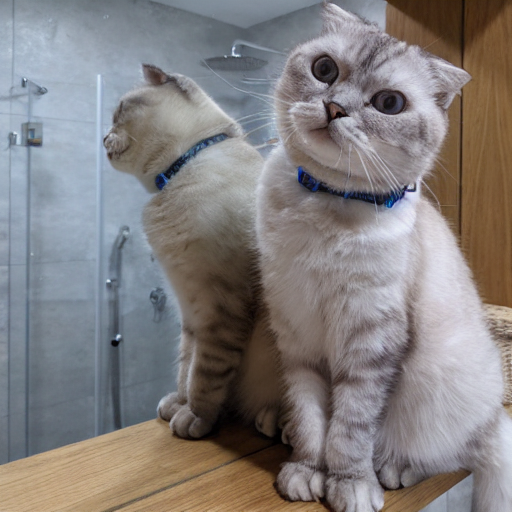

In [9]:
Image.fromarray(image_rec)

  0%|          | 0/50 [00:00<?, ?it/s]

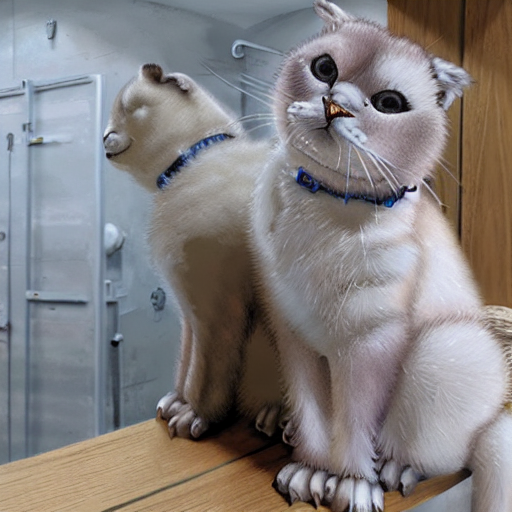

In [16]:
import torch
gen = torch.Generator(device=device)

gen.manual_seed(48)
out = pipe(prompt=prompt, 
           generator=gen, 
           num_images_per_prompt=1, 
           guidance_scale=GUIDANCE_SCALE,
           num_inference_steps = NUM_DDIM_STEPS,
           editing_prompt=['oil painting, drawing'],         # Concepts to apply
           reverse_editing_direction=[False],                # Direction of guidance
           edit_warmup_steps=[35],                           # Warmup period for each concept
           edit_guidance_scale=[2000],                       # Guidance scale for each concept
           edit_threshold=[-0.2],                            # Threshold for each concept. Note that positive guidance needs negative thresholds and vice versa
           edit_weights=[1.2],                               # Weights of the individual concepts against each other
           edit_momentum_scale=0.25,                         # Momentum scale that will be added to the latent guidance
           edit_mom_beta=0.6,                                # Momentum beta
           latents = latents,
           uncond_embeddings = uncond_embeddings)
out.images[0]